# Fraud detection

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn import preprocessing

import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from sklearn.metrics import mean_squared_error
from scipy import ndimage


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization,concatenate
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers


# GPU support
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2024-10-17 19:14:14.143068: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-17 19:14:14.149895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 19:14:14.157575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 19:14:14.159887: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 19:14:14.166117: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Read dataset
dataset = pd.read_csv('creditcard.csv')
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
normal_count = dataset.Class[dataset["Class"]==0].count()
froud_count = dataset.Class[dataset["Class"]==1].count()
print("Normal transactions: ", normal_count)
print("Froud transactions: ", froud_count)

Normal transactions:  284315
Froud transactions:  492


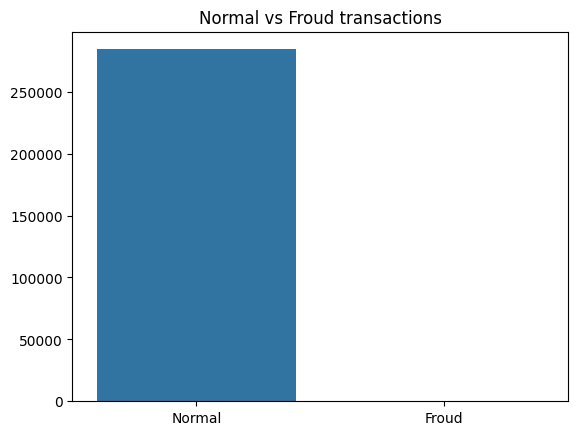

In [4]:
# Plot the normal and froud transactions
sns.barplot(x=['Normal', 'Froud'], y=[normal_count, froud_count])
plt.title('Normal vs Froud transactions')
plt.show()

In [5]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
# Split the dataset
dataset['Time'] = StandardScaler().fit_transform(dataset['Time'].values.reshape(-1, 1))
dataset['Amount'] = StandardScaler().fit_transform(dataset['Amount'].values.reshape(-1, 1))

X = dataset.drop(['Class'], axis=1)
y = dataset['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the data
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (227845, 30)
X_test shape:  (56962, 30)


In [24]:
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam

# Model Parameters
input_dim = X_train.shape[1]
encoded_dim = 15

# Model Definition
input_shape = Input(shape=(input_dim,))
print("Input dimension:", input_dim)
print("Input shape:", input_shape)


def encoder_module(x):
    encoded = Dense(encoded_dim * 4, activation='tanh')(x)  # 60 units
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(encoded_dim * 2, activation='relu')(encoded)  # 30 units
    return encoded

def decoder_module(x):
    decoded = Dense(encoded_dim * 2, activation='relu')(x)  # 30 units
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.2)(decoded)
    decoded = Dense(encoded_dim * 4, activation='tanh')(decoded)  # 60 units
    decoded = Dense(input_dim, activation='linear')(decoded)  # Final layer must output (None, 30)
    return decoded

# Build the encoder and decoder
encoder = Model(input_shape, encoder_module(input_shape))
encoded_output = encoder(input_shape)
decoder = Model(input_shape, decoder_module(encoded_output))

# Create the autoencoder model
autoencoder = Model(input_shape, decoder(encoder(input_shape)))

# Compile the model
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Print model summary to verify shapes
autoencoder.summary()

Input dimension: 30
Input shape: <KerasTensor shape=(None, 30), dtype=float32, sparse=False, name=keras_tensor_49>


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_7 (Functional)       │ (None, 30)             │         3,930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_8 (Functional)       │ (None, 30)             │         8,670 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,670 (33.87 KB)

 Trainable params: 8,490 (33.16 KB)

 Non-trainable params: 180 (720.00 B)

In [25]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output from the fit method
history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=64, validation_data=(X_test, X_test))    

Epoch 1/20
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.0851 - val_loss: 0.6125
Epoch 2/20
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.6908 - val_loss: 0.5127
Epoch 3/20
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.6028 - val_loss: 0.4464
Epoch 4/20
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.5725 - val_loss: 0.4027
Epoch 5/20
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.5137 - val_loss: 0.3743
Epoch 6/20
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 3s 951us/step - loss: 0.5062 - val_loss: 0.3576
Epoch 7/20
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.4976 - val_loss: 0.3422
Epoch 8/20
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.4589 - val_loss: 0.3313
Epoch 9/20
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.4455 - val_loss: 0.3220
Epoch 10/20
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.4361 - val_loss: 0.3118
Epoch 11/20
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.4338 - val_loss: 0.3075
Epoch 12/20
3561/3561 ━━━━━━

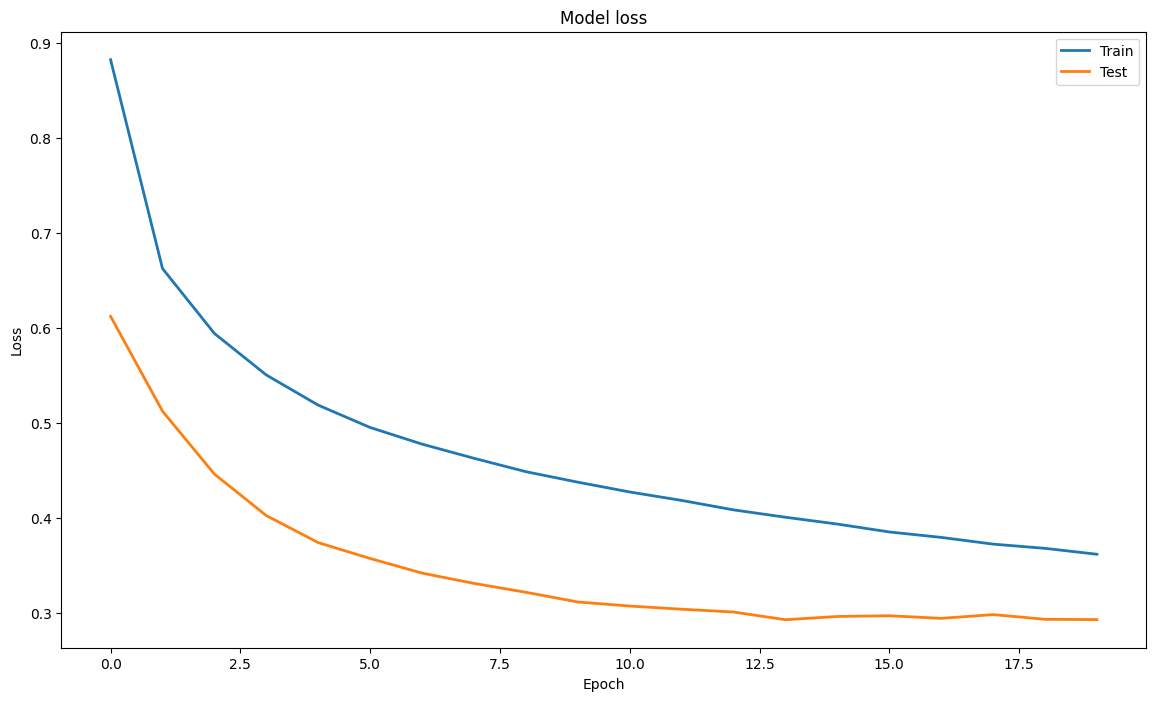

In [28]:
plt.figure(figsize=(14, 8))
plt.plot(history.history['loss'], linewidth=2, label='Train')
plt.plot(history.history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [29]:
X_test_predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})
error_df.describe()

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 942us/step


,Reconstruction_error,True_class
count,56962.000000,56962.000000
mean,0.293232,0.001720
std,1.874238,0.041443
min,0.028908,0.000000
25%,0.117013,0.000000
50%,0.158608,0.000000
75%,0.236887,0.000000
max,183.482785,1.000000


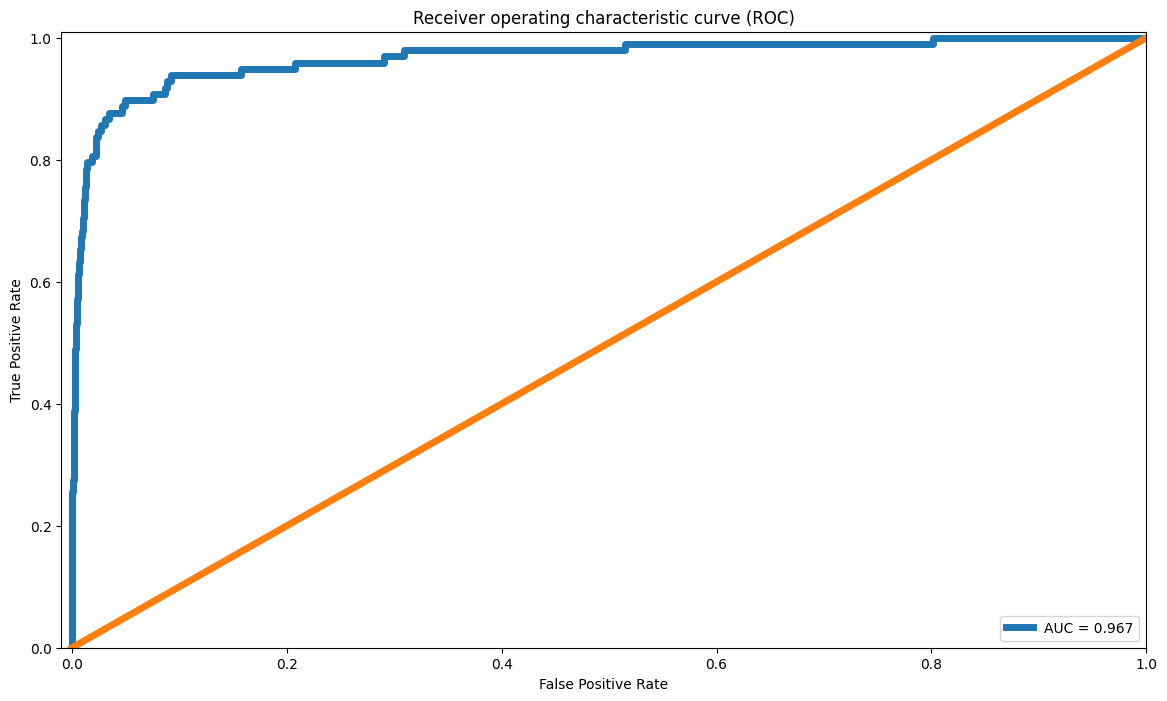

In [31]:
from sklearn.metrics import roc_curve, auc

false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class,
                                                      error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.figure(figsize=(14, 8))
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

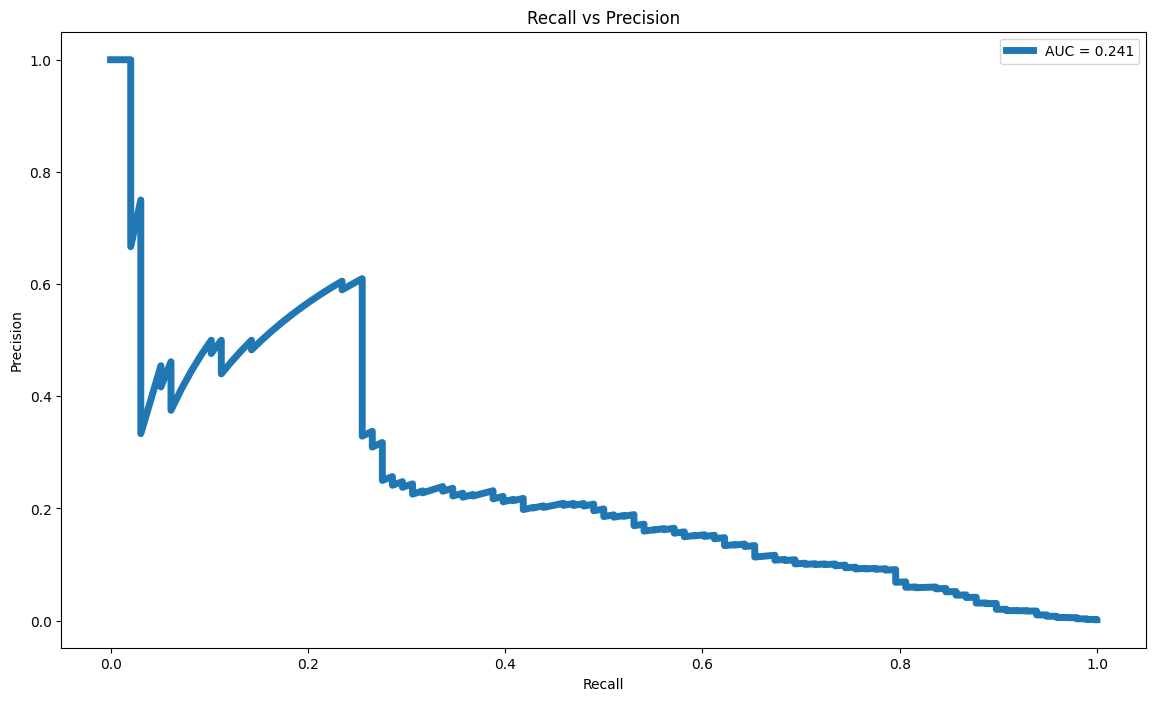

In [32]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class,
                                                               error_df.Reconstruction_error)

pr_auc = auc(recall_rt, precision_rt,)

plt.figure(figsize=(14, 8))
plt.plot(recall_rt, precision_rt, linewidth=5, label='AUC = %0.3f'% pr_auc)
plt.legend(loc='upper right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

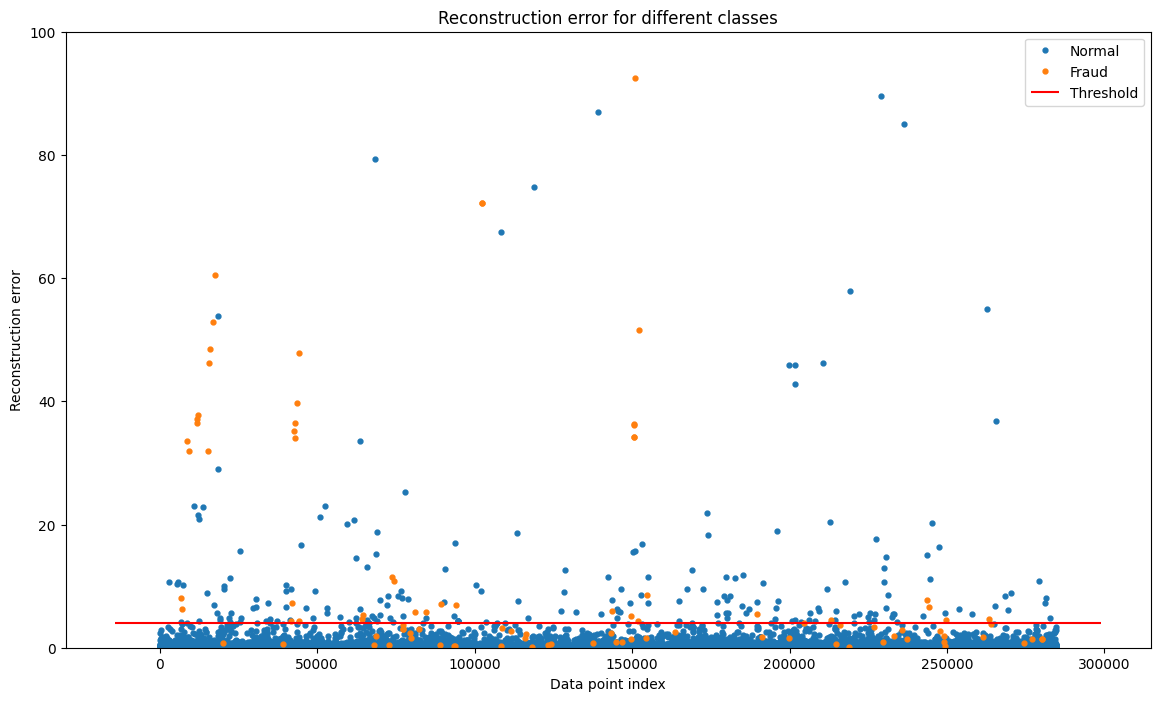

In [34]:
threshold_fixed = 4
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(14, 8))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1],
          colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.ylim(0, 100)
plt.show();

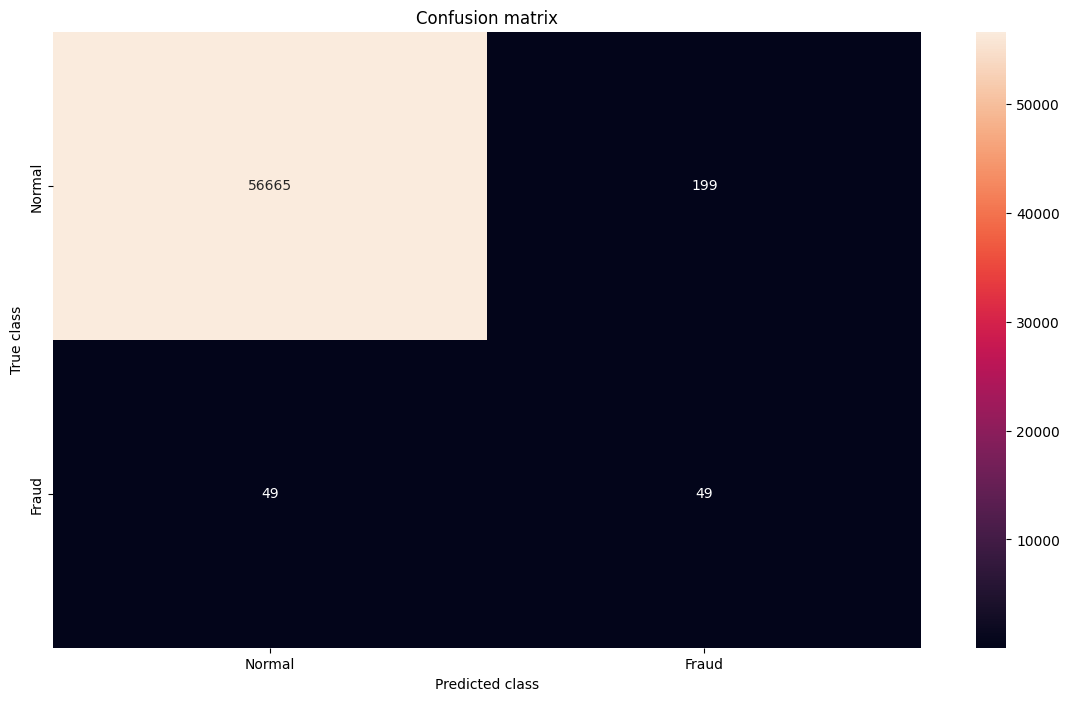

In [38]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

LABELS = ["Normal", "Fraud"]    
plt.figure(figsize=(14, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
